# Group Project - 1

| Sl.no | Team Member | UT EID |
|--- | ------ | --- |
| 1 | Disha Gandhi                  | DSG2258 |
| 2 | Chyavan Mysore Chandrashekar  | CM65624 |
| 3 | Muskaan Singhania             | MS88283 |
| 4 | Amritangshu Mukherjee         | AM222239 |

<hr>

### Imports Required

In [8]:
from numpy import array, zeros, nan_to_num, inf
import gurobipy as gp
from pandas import read_csv, Series, DataFrame
import warnings
NoneType = type(None)
warnings.filterwarnings('ignore')

### Generic function to solve inequations

In [3]:
def solve_inequations(coefs, n_vars, sense, rhs, objective, minimize=False, ubound=None):
    optimizer = gp.GRB.MINIMIZE if minimize else gp.GRB.MAXIMIZE
    ojModel = gp.Model()
    if type(ubound) == NoneType:
        ojModX = ojModel.addMVar(n_vars)
    else:
        ojModX = ojModel.addMVar(n_vars, ub=ubound)
    ojModCon = ojModel.addMConstrs(coefs, ojModX, sense, rhs)
    ojModel.setMObjective(None, objective, 0, sense=optimizer)
    ojModel.Params.OutputFlag = 0
    ojModel.Params.TimeLimit = 3600
    ojModel.optimize()
    return ojModX, ojModCon, ojModel

### Importing `csv` files and setting up global constants

In [4]:
roi_data = read_csv("ROI_data.csv").set_index("Platform")
display(roi_data)

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
Platform,,,,,,,,,,
ROI,0.031,0.049,0.024,0.039,0.016,0.024,0.046,0.026,0.033,0.044
Second Firms ROI Estimate,0.049,0.023,0.024,0.039,0.044,0.046,0.026,0.019,0.037,0.026


In [5]:
roi_mat = read_csv("roi_mat.csv").rename(columns= {"Unnamed: 0": "Month"}).set_index("Month")
display(roi_mat)

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
Month,,,,,,,,,,
January,4.0,3.6,2.4,3.9,3.0,3.5,3.6,2.25,3.5,3.5
February,4.0,3.9,2.7,3.8,4.3,3.2,2.7,1.80,3.7,3.5
March,3.5,2.9,3.1,3.8,2.4,4.1,3.7,2.60,4.2,2.5
April,3.8,3.1,2.4,4.4,2.4,3.8,3.7,2.50,3.6,2.9
May,3.5,3.2,1.9,3.4,2.7,2.7,3.9,2.20,4.5,3.9
June,4.0,3.2,2.7,3.4,3.4,3.0,4.5,2.10,3.8,4.1
July,3.9,3.6,2.0,4.4,3.9,3.7,4.3,1.80,4.0,3.8
August,4.2,3.3,2.8,4.2,2.0,3.7,3.6,1.50,4.4,4.3
September,4.1,2.8,2.5,4.2,2.9,3.7,2.8,2.50,4.0,3.4


In [6]:
budget = 10000000
upper_bound_value = 3000000
stable_allocation_cutoff_value = 1000000

cons_1_cols = ["Print", "TV", "Facebook", "Email"]
indices_cons_1 = [list(roi_data.columns).index(x) for x in cons_1_cols]
indices_mat_cons_1 = [list(roi_mat.columns).index(x) for x in cons_1_cols]
cons_1 = [1., 1., -1., -1.]
cons_1_sense = '<'

cons_2_cols = ["SEO", "AdWords",    "Facebook", "LinkedIn", "Instagram", "Snapchat", "Twitter"]
indices_cons_2 = [list(roi_data.columns).index(x) for x in cons_2_cols]
indices_mat_cons_2 = [list(roi_mat.columns).index(x) for x in cons_2_cols]
cons_2 = [-2., -2., 1., 1., 1., 1., 1.]
cons_2_sense = '>'

### Q.1, Q.2, Q.3

In [10]:
# 1. Objective
obj_1 = array(roi_data.iloc[0].values)
n_var = len(roi_data.iloc[0].values)

# 2. Matrix A - Coefficients
A = zeros((3, n_var))
    # The amount invested in print and TV should be no more than the amount spent on Facebook and Email.
A[0,indices_cons_1] = cons_1
    # The total amount used in social media should be at least twice of SEO and AdWords
A[1,indices_cons_2] = cons_2
    # The total investment should not exceed the budget
A[2,:] = [1.]*n_var

# 3. Sense
sense = array([cons_1_sense, cons_2_sense, '<'])

# 4. RHS
rhs = array([0, 0, budget])

# 5. Upper bound - For each platform, the amount invested should be no more than $3M
ubound = array([upper_bound_value]*n_var)


# 6. Solve
objModX_1, objModCon_1, objModel_1 = solve_inequations(A, n_var, sense, rhs, obj_1, ubound=ubound)

print("The Maximum value of the objective function - i.e. First ROI: ", end="")
display(round(objModel_1.objVal, 5))
print("\nThe investments to obtain the objective function: ", end="")
Alloc1= DataFrame(objModX_1.x, index=roi_data.columns, columns=["Allocation"])
display(Alloc1)

The Maximum value of the objective function - i.e. First ROI: 

456000.0


The investments to obtain the objective function: 

,Allocation
Print,0.0
TV,3000000.0
SEO,0.0
AdWords,1000000.0
Facebook,0.0
LinkedIn,0.0
Instagram,3000000.0
Snapchat,0.0
Twitter,0.0
Email,3000000.0


### Q.4

In [11]:
# 1. Objective
obj_2 = array(roi_data.iloc[1].values)
n_var = len(roi_data.iloc[1].values)

# 2. Matrix A - Coefficients
A = zeros((3, n_var))
    # The amount invested in print and TV should be no more than the amount spent on Facebook and Email.
A[0,indices_cons_1] = cons_1
    # The total amount used in social media should be at least twice of SEO and AdWords
A[1,indices_cons_2] = cons_2
    # The total investment should not exceed the budget
A[2,:] = [1.]*n_var

# 3. Sense
sense = array([cons_1_sense, cons_2_sense, '<'])

# 4. RHS
rhs = array([0, 0, budget])

# 5. Upper bound - For each platform, the amount invested should be no more than $3M
ubound = array([upper_bound_value]*n_var)


# 6. Solve
objModX_2, objModCon_2, objModel_2 = solve_inequations(A, n_var, sense, rhs, obj_2, ubound=ubound)

print("The Maximum value of the objective function - i.e. Second ROI: ", end="")
display(round(objModel_2.objVal, 5))
print("\nThe investments to obtain the objective function: ", end="")
Alloc2 = DataFrame(objModX_2.x, index=roi_data.columns, columns=["Allocation"])
display(Alloc2)

The Maximum value of the objective function - i.e. Second ROI: 

456000.0


The investments to obtain the objective function: 

,Allocation
Print,3000000.0
TV,0.0
SEO,0.0
AdWords,1000000.0
Facebook,3000000.0
LinkedIn,3000000.0
Instagram,0.0
Snapchat,0.0
Twitter,0.0
Email,0.0


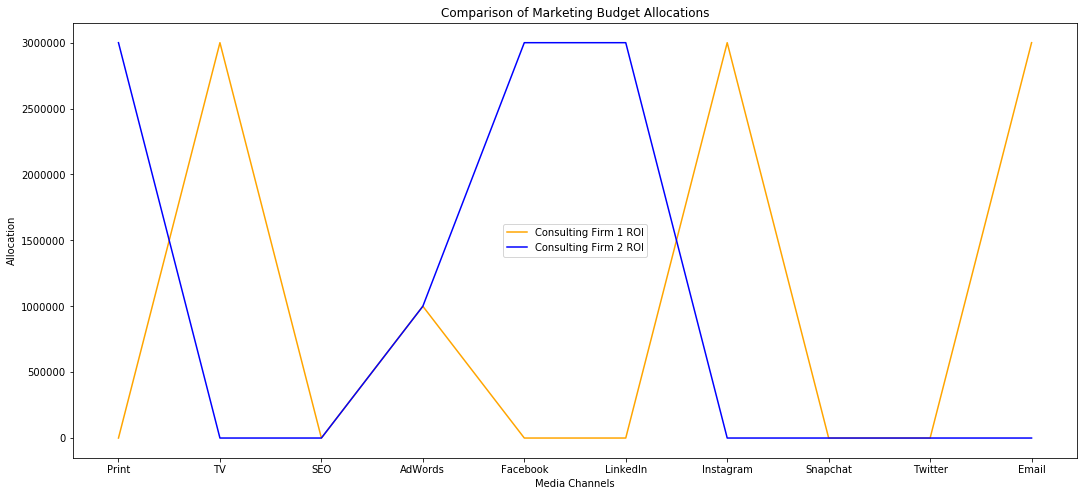

In [17]:
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(18,8))
ax1 = fig1.add_subplot(111)

ax1.plot(Alloc1['Allocation'], color='orange', label='Consulting Firm 1 ROI')
ax1.plot(Alloc2['Allocation'], color='blue', label='Consulting Firm 2 ROI')
plt.title('Comparison of Marketing Budget Allocations')
plt.xlabel('Media Channels')
plt.ylabel('Allocation')
plt.legend()

### Q.5

**Are the allocations the same?**

*Answer:*
> No, the allocations are different when comparing the two cases of different ROIs provided by the two firms.

**Assuming the first ROI data is correct, if you were to use the second allocation (the allocation that assumed the second ROI data was correct) how much lower would the objective be relative to the optimal objective (the one that uses the first ROI data and the first allocation)?**

*Answer:*

In [18]:
cost_new_12 = obj_1 @ objModX_2.x
print("Considering the First ROI is correct, and using the Second Allocation")
print(f"The value of the objective obtained would be: {cost_new_12}")
print(f"This value would be lesser than the optimal objective by: {objModel_2.objVal - cost_new_12}")

Considering the First ROI is correct, and using the Second Allocation
The value of the objective obtained would be: 252000.0
This value would be lesser than the optimal objective by: 204000.0


**Assuming the second ROI data is correct, if you used the first allocation how much lower would the objective be relative to the optimal objective?**

*Answer:*

In [19]:
cost_new_21 = obj_2 @ objModX_1.x
print("Considering the Second ROI is correct, and using the First Allocation")
print(f"The value of the objective obtained would be: {cost_new_21}")
print(f"This value would be lesser than the optimal objective by: {objModel_1.objVal - cost_new_21}")

Considering the Second ROI is correct, and using the First Allocation
The value of the objective obtained would be: 264000.0
This value would be lesser than the optimal objective by: 192000.0


**Do you think the third constraint above, based on your boss’ experience, is useful?**

*Answer:*

In [20]:
# 1. Objective
obj_3 = array(roi_data.iloc[0].values)
n_var = len(roi_data.iloc[0].values)

# 2. Matrix A - Coefficients
A = zeros((3, n_var))
    # The amount invested in print and TV should be no more than the amount spent on Facebook and Email.
A[0,indices_cons_1] = cons_1
    # The total amount used in social media should be at least twice of SEO and AdWords
A[1,indices_cons_2] = cons_2
    # The total investment should not exceed the budget
A[2,:] = [1.]*n_var

# 3. Sense
sense = array([cons_1_sense, cons_2_sense, '<'])

# 4. RHS
rhs = array([0, 0, budget])


# 5. Solve
objModX_3, objModCon_3, objModel_3 = solve_inequations(A, n_var, sense, rhs, obj_3)

print("The Maximum value of the objective function - i.e. First ROI: ", end="")
display(round(objModel_3.objVal, 5))
print("\nThe investments to obtain the objective function: ", end="")
display(DataFrame(objModX_3.x, index=roi_data.columns, columns=["Allocation"]))

The Maximum value of the objective function - i.e. First ROI: 

465000.0


The investments to obtain the objective function: 

,Allocation
Print,0.0
TV,5000000.0
SEO,0.0
AdWords,0.0
Facebook,0.0
LinkedIn,0.0
Instagram,0.0
Snapchat,0.0
Twitter,0.0
Email,5000000.0


In [21]:
# 1. Objective
obj_4 = array(roi_data.iloc[1].values)
n_var = len(roi_data.iloc[1].values)

# 2. Matrix A - Coefficients
A = zeros((3, n_var))
    # The amount invested in print and TV should be no more than the amount spent on Facebook and Email.
A[0,indices_cons_1] = cons_1
    # The total amount used in social media should be at least twice of SEO and AdWords
A[1,indices_cons_2] = cons_2
    # The total investment should not exceed the budget
A[2,:] = [1.]*n_var

# 3. Sense
sense = array([cons_1_sense, cons_2_sense, '<'])

# 4. RHS
rhs = array([0, 0, budget])


# 5. Solve
objModX_4, objModCon_4, objModel_4 = solve_inequations(A, n_var, sense, rhs, obj_4)

print("The Maximum value of the objective function - i.e. Second ROI: ", end="")
display(round(objModel_4.objVal, 5))
print("\nThe investments to obtain the objective function: ", end="")
display(DataFrame(objModX_4.x, index=roi_data.columns, columns=["Allocation"]))

The Maximum value of the objective function - i.e. Second ROI: 

465000.0


The investments to obtain the objective function: 

,Allocation
Print,5000000.0
TV,0.0
SEO,0.0
AdWords,0.0
Facebook,5000000.0
LinkedIn,0.0
Instagram,0.0
Snapchat,0.0
Twitter,0.0
Email,0.0


In [22]:
print("No, for the first allocation, we can see that removing the 3rd contraint would give us additional", \
    objModel_3.ObjVal - objModel_1.ObjVal)

print("\nNo, for the second allocation also, we can see that removing the 3rd contraint would give us additional", \
    objModel_4.ObjVal - objModel_2.ObjVal)

No, for the first allocation, we can see that removing the 3rd contraint would give us additional 9000.0

No, for the second allocation also, we can see that removing the 3rd contraint would give us additional 9000.0


### Q.6

*Answer:*

In [23]:
DataFrame(
    [
        Series(objModX_1.SAObjLow, index=roi_data.columns),
        Series(objModX_1.SAObjUp, index=roi_data.columns)
    ], index=["Lower Bound", "Upper Bound"]
).T

,Lower Bound,Upper Bound
Print,-inf,0.049
TV,0.039,0.062
SEO,-inf,0.039
AdWords,0.033,0.046
Facebook,-inf,0.029
LinkedIn,-inf,0.039
Instagram,0.039,inf
Snapchat,-inf,0.039
Twitter,-inf,0.039
Email,0.029,inf


> ROIs of each medium can change between the upper-bound and lower-bound mentioned in the table and we would still get the same optimal allocation. Let us double check this by looking at the allocations when all the ROIs have the value of their upper-bound.

In [24]:
# 1. Objective
obj_5 = array(nan_to_num(objModX_1.SAObjUp))
n_var = len(roi_data.iloc[0].values)

# 2. Matrix A - Coefficients
A = zeros((3, n_var))
    # The amount invested in print and TV should be no more than the amount spent on Facebook and Email.
A[0,indices_cons_1] = cons_1
    # The total amount used in social media should be at least twice of SEO and AdWords
A[1,indices_cons_2] = cons_2
    # The total investment should not exceed the budget
A[2,:] = [1.]*n_var

# 3. Sense
sense = array([cons_1_sense, cons_2_sense, '<'])

# 4. RHS
rhs = array([0, 0, budget])

# 5. Upper bound - For each platform, the amount invested should be no more than $3M
ubound = array([upper_bound_value]*n_var)


# 6. Solve
objModX_5, objModCon_5, objModel_5 = solve_inequations(A, n_var, sense, rhs, obj_5, ubound=ubound)

print("\nThe investments to obtain the objective function with upper-bound: ", end="")
display(DataFrame(objModX_5.x, index=roi_data.columns, columns=["Allocation"]))


The investments to obtain the objective function with upper-bound: 

,Allocation
Print,0.0
TV,3000000.0
SEO,0.0
AdWords,1000000.0
Facebook,0.0
LinkedIn,0.0
Instagram,3000000.0
Snapchat,0.0
Twitter,0.0
Email,3000000.0


> We can see this is the same allocation as the allocation for we got for the First ROI data.

### Q.7

In [26]:
prev_month_return = 0
col_names = list(roi_mat.columns.values) + ["Budget", "Return"]
monthly_allocations = DataFrame(
    columns=col_names
)

for month in roi_mat.index.values:
    # 1. Objective
    obj = array(roi_mat.loc[month].values/100)
    n_var = len(roi_mat.loc[month].values)

    # 2. Matrix A - Coefficients
    A = zeros((3, n_var))
        # The amount invested in print and TV should be no more than the amount spent on Facebook and Email.
    A[0,indices_mat_cons_1] = cons_1
        # The total amount used in social media should be at least twice of SEO and AdWords
    A[1,indices_mat_cons_2] = cons_2
        # The total investment should not exceed the budget
    A[2,:] = [1.]*n_var

    # 3. Sense
    sense = array([cons_1_sense, cons_2_sense, '<'])

    # 4. RHS
    rhs = array([0, 0, budget + 0.5*prev_month_return])

    # 5. Upper bound - For each platform, the amount invested should be no more than $3M
    ubound = array([upper_bound_value]*n_var)


    # 6. Solve
    objModX, objModCon, objModel = solve_inequations(A, n_var, sense, rhs, obj, ubound=ubound)

    monthly_allocations.loc[month] = Series(list(objModX.x) + [budget + 0.5*prev_month_return, obj @ objModX.x], index=col_names)
    prev_month_return = obj @ objModX.x
    
monthly_allocations = monthly_allocations.round(1)
display(monthly_allocations)
print("The total returns at the end of the year is: $", \
    round((monthly_allocations.iloc[:-1, -1].sum()*0.5) + monthly_allocations.iloc[-1, -1],2))

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email,Budget,Return
January,3000000.0,0.0,0.0,1333333.3,0.0,0.0,2666666.7,0.0,0.0,3000000.0,10000000.0,373000.0
February,3000000.0,0.0,0.0,2395500.0,3000000.0,0.0,0.0,0.0,1791000.0,0.0,10186500.0,406296.0
March,0.0,0.0,0.0,3000000.0,0.0,3000000.0,1203148.0,0.0,3000000.0,0.0,10203148.0,407516.5
April,0.0,0.0,0.0,3000000.0,0.0,3000000.0,3000000.0,0.0,1203758.2,0.0,10203758.2,400335.3
May,1200167.6,0.0,0.0,0.0,0.0,0.0,3000000.0,0.0,3000000.0,3000000.0,10200167.6,411005.9
June,3000000.0,0.0,0.0,0.0,0.0,0.0,3000000.0,0.0,1205502.9,3000000.0,10205502.9,423809.1
July,0.0,0.0,0.0,3000000.0,1211904.6,0.0,3000000.0,0.0,3000000.0,0.0,10211904.6,428264.3
August,2714132.1,0.0,0.0,1500000.0,0.0,0.0,0.0,0.0,3000000.0,3000000.0,10214132.1,437993.5
September,609498.4,0.0,0.0,3000000.0,0.0,3000000.0,0.0,0.0,3000000.0,609498.4,10218996.8,402712.4
October,0.0,0.0,0.0,3000000.0,0.0,3000000.0,3000000.0,0.0,0.0,1201356.2,10201356.2,371443.4


The total returns at the end of the year is: $ 2684496.6


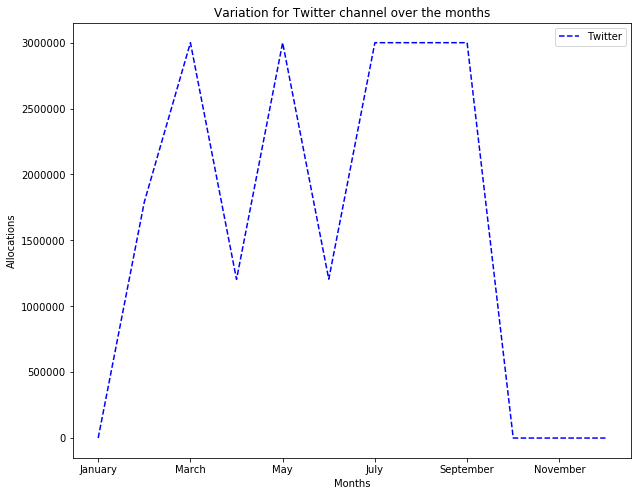

In [61]:
plt.figure(figsize=(10,8))
monthly_allocations['Twitter'].plot(label='Twitter', color='blue', linestyle='dashed')
plt.title('Variation for Twitter channel over the months')
plt.xlabel('Months')
plt.ylabel('Allocations')
plt.legend()

### Q.8

> The current monthly allocations are not stable as the changes in allocation are more than \$1M in many cases <br>
>  
> Making the solution *stable* is only going to make the solution more constraining, and hence the optimal solution will be lesser than (or equal to) the solution we have obtained now. That is, the total returns after the year would either decrease or remain the same. <br>
>  
> One such solution is when the company concentrates on maximizing the overall returns after the whole year instead of maximizing the returns every month. With this objective, we can use the same methodology as we implemented in the STF (Short Term Financing) problem.
> * The calculations now become a linear programming problem in 120 variables - each variable representing the amount that can be allocated to each media in a certain month - and 12 variables to track the 12 more returns of each months.
> * Further, we should also add 220 additional constraints (11*2 for each medium's investments sequentially comparing the values for 12 months and constraining the change to less than 1 million). <br>
>       For instance, for `Print` medium, if we denote $X_{print,Jan}$ as the investment in January, $X_{print,Feb}$ as the investment in February, and so on. The constraints for a *stable* solution will be <br>
> $$ X_{print,Jan} - X_{print,Feb} < \$1M $$
> $$ and $$
> $$ X_{print,Jan} - X_{print,Feb} > -\$1M $$

In [51]:
cols = len(roi_mat.loc[month].values)
rows = len(roi_mat)
n_var = cols*rows + rows

obj = zeros(n_var)
obj[-rows:-1] = [0.5]*(rows-1)
obj[-1] = 1

A = zeros((4*rows + 2*(rows-1)*cols, n_var))
for row in range(rows):
    # First Constraint for each month
    A[row, array(indices_mat_cons_1) + row*cols] = cons_1
    
    # Second Constraint for each month
    A[rows+row, array(indices_mat_cons_2) + row*cols] = cons_2
    
    # New Constraint for each month - after adding half the previous month's return
    A[2*rows+row, row*cols: (row+1)*cols] = [1.]*cols
    if (row != 0):
        A[2*rows+row, rows*cols+row-1] = -0.5
    
    # New constraints from the pervious objective functions
    A[3*rows+row, row*cols: (row+1)*cols] = roi_mat.iloc[row].values/100
    A[3*rows+row, rows*cols+row] = -1

    # Adding the stability constraint
    if row != rows - 1:
        for col in range(cols):
            A[4*rows+row*cols+col, [row*cols + col, (row+1)*cols + col]] = [-1, 1]
            A[4*rows+row*cols+col + (rows-1)*cols, [row*cols + col, (row+1)*cols + col]] = [-1, 1]

sense = array(
    [cons_1_sense]*rows + [cons_2_sense]*rows + ['<']*rows + ['=']*rows + ['<']*((rows-1)*cols) + ['>']*((rows-1)*cols)
)

b = array(
    [0]*(2*rows) + [budget]*rows + [0]*rows + [stable_allocation_cutoff_value]*((rows-1)*cols) + [-stable_allocation_cutoff_value]*((rows-1)*cols)
)

ubound = array([upper_bound_value]*(rows*cols) + [inf]*rows)

objModX, objModCon, objModel = solve_inequations(A, n_var, sense, b, obj, ubound=ubound)

z = zeros((rows,cols+2))
for i in range(rows):
    if i == 0:
        z[i, :] = list(objModX.x[i*cols:(i+1)*cols]) + [budget, objModX.x[rows*cols+i]]
    else:
        z[i, :] = list(objModX.x[i*cols:(i+1)*cols]) + [budget+ objModX.x[rows*cols+i-1]*0.5, objModX.x[rows*cols+i]]

stable_monthly_allocations = DataFrame(z, columns=col_names, index=roi_mat.index.values)
stable_monthly_allocations = stable_monthly_allocations.round(1)
display(stable_monthly_allocations)
print("The total returns at the end of the year is: $", \
    round((stable_monthly_allocations.iloc[:-1, -1].sum()*0.5) + stable_monthly_allocations.iloc[-1, -1],2))

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email,Budget,Return
January,2592048.1,0.0,0.0,1804316.7,597046.2,0.0,1000000.0,0.0,2011587.2,1995001.8,10000000.0,368192.3
February,1597046.2,995001.8,0.0,2000000.0,1597046.2,1000000.0,0.0,0.0,2000000.0,995001.8,10184096.1,388185.0
March,597046.2,0.0,0.0,3000000.0,597046.2,2000000.0,1000000.0,0.0,3000000.0,0.0,10194092.5,394225.7
April,598556.4,0.0,0.0,3000000.0,0.0,1000000.0,2000000.0,0.0,3000000.0,598556.4,10197112.9,392103.3
May,597495.2,0.0,0.0,2000000.0,0.0,0.0,3000000.0,0.0,3000000.0,1598556.4,10196051.6,403256.0
June,1597495.2,0.0,0.0,1005576.4,0.0,0.0,3000000.0,0.0,2000000.0,2598556.4,10201628.0,415630.2
July,1601119.4,0.0,0.0,2005576.4,2562.9,0.0,2000000.0,0.0,3000000.0,1598556.4,10207815.1,417534.1
August,1770620.9,0.0,0.0,1839589.7,0.0,0.0,1000000.0,0.0,3000000.0,2598556.4,10208767.1,431366.8
September,2770620.9,0.0,0.0,1674441.6,348883.1,1000000.0,0.0,0.0,2000000.0,2421737.8,10215683.4,393378.7
October,2000000.0,0.0,0.0,2258317.2,1348883.1,1167751.3,1000000.0,0.0,1000000.0,1421737.8,10196689.3,346729.4


The total returns at the end of the year is: $ 2611099.35


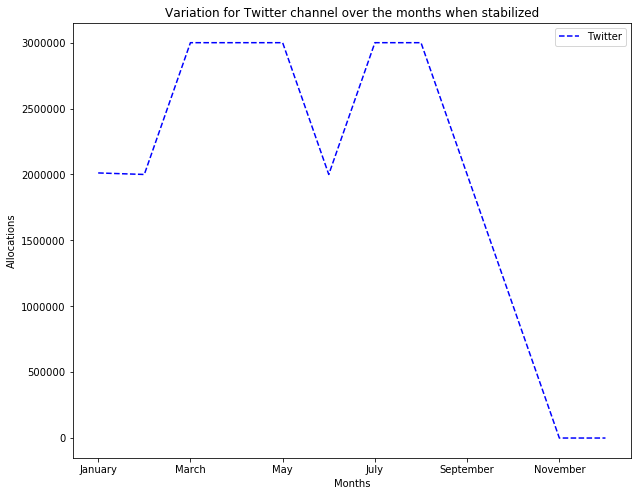

In [62]:
plt.figure(figsize=(10,8))
stable_monthly_allocations['Twitter'].plot(label='Twitter', color='blue', linestyle='dashed')
plt.title('Variation for Twitter channel over the months when stabilized')
plt.xlabel('Months')
plt.ylabel('Allocations')
plt.legend()